# BERTopic news processor

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta, datetime

plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams['figure.facecolor'] = 'white'
#plt.style.use('dark_background')

comma_strip = lambda x: x.rstrip(",")

import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation

mystem = Mystem() 
russian_stopwords = stopwords.words("russian")

def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords \
              and token != " " \
              and token.strip() not in punctuation
              and token.strip() not in ["«", "»", "“", "”"]]
    text = " ".join(tokens)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dormant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
try:
    news = pd.read_csv('../DATA-MINING/SCRAPED-DATA/LEMM-NEWS-2018-1-1-2022-9-1.csv',
                       sep='\t',
                       on_bad_lines='skip')
except:
    news = pd.read_csv('../DATA-MINING/SCRAPED-DATA/NEWS-2018-1-1-2022-9-1.csv',
                       sep='\t',
                       on_bad_lines='skip')
    news['title'] = news['title'].apply(preprocess_text)
    news.to_csv('../DATA-MINING/SCRAPED-DATA/LEMM-NEWS-2018-1-1-2022-9-1.csv',
                sep='\t',
                index=False)
    
    # validate working file
    news = pd.read_csv('../DATA-MINING/SCRAPED-DATA/LEMM-NEWS-2018-1-1-2022-9-1.csv',
                       sep='\t',
                       on_bad_lines='skip')

In [3]:
print(f'Number of news headers: {len(news)}')
news.head()

Number of news headers: 411713


,date,title
0,2018-01-01,потанин оставаться вода
1,2018-01-01,автор хит 1 1 устраивать праздничный переполох
2,2018-01-01,северный корея принимать участие олимпиада южный
3,2018-01-01,зимний сказка петербург продлиться недолго
4,2018-01-01,алкогольный энергетик показывать красный свет


In [4]:
datify = lambda x: datetime.strptime(x, '%Y-%m-%d')
textify = lambda x: x.strftime('%Y-%m-%d')

start_d, end_d = datify(min(news['date'])), datify(max(news['date']))
delta_d = end_d - start_d
num_days = delta_d.days

print(f"From {textify(start_d)} to {textify(end_d)}")
print(f"Number of days: {num_days}")

num_bins = int(num_days/30)
print(f"{num_bins} is going to be the number of monthly bins.")

From 2018-01-01 to 2022-09-01
Number of days: 1704
56 is going to be the number of monthly bins.


In [5]:
news.tail()

,date,title
411708,2022-09-01,петербуржец напоминать изменяться общественный...
411709,2022-09-01,обгорать трешка проспект наука вытаскивать пос...
411710,2022-09-01,называть креативный двор санкт-петербург котор...
411711,2022-09-01,первый сентябрь петербург открываться 7 социал...
411712,2022-09-01,гороскоп весь знак зодиак 1 сентябрь 2022 год ...


Number of topics: 47


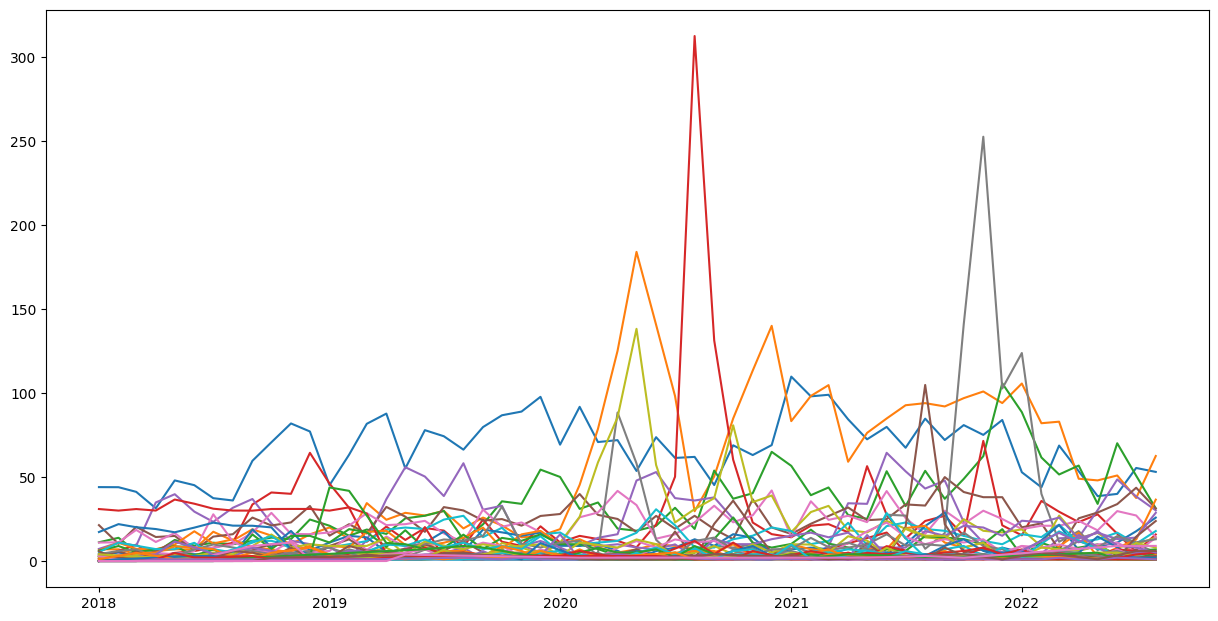

In [10]:
from bertopic import BERTopic
from dateutil.relativedelta import relativedelta

# Topics to visualize (-2 to include all)
num_of_topics = -2

# Number of topics after reduction
reduce_topics_to = 50

# Start topic
start_topic = 2

timestamps = news['date'].to_list()
titles = news['title'].to_list()

try:
    topic_df = pd.read_csv('./PROCESSED-DATA/TOPICS.csv', sep=',', on_bad_lines='skip')
    topic_df.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
    topic_df.set_index('Date', inplace=True)
    topic_df.index = topic_df.index.map(datify)
    topic_df = topic_df.iloc[:,start_topic:num_of_topics+1]
except:
    topic_model = BERTopic(embedding_model='distiluse-base-multilingual-cased-v1',
                           verbose=True)
    topics, probs = topic_model.fit_transform(titles)
    topic_model.reduce_topics(titles, nr_topics=reduce_topics_to)
    topic_labels = topic_model.generate_topic_labels(nr_words=3,
                                                     topic_prefix=True,
                                                     word_length=10,
                                                     separator="_")
    
    topics_over_time = topic_model.topics_over_time(titles, timestamps, nr_bins=num_bins)
    topic_df = pd.DataFrame(topics_over_time)
    topic_df.rename(columns={"Timestamp": "Date"}, inplace=True)
    topic_df.fillna(0.0, inplace=True)
    
    new_index = pd.date_range(start=textify(start_d),
                              end=textify(end_d + relativedelta(months=-1)),
                              freq='MS')
    
    topic_df = topic_df.pivot(index="Date",
                              columns="Topic",
                              values="Frequency")
    
    topic_df = topic_df.reindex(topic_df.index.union(new_index)).interpolate(method='time')
    topic_df = topic_df.reindex(new_index)
    topic_df.set_axis(topic_labels, axis=1, inplace=True)
    topic_df.fillna(0.0, inplace=True)
    
    topic_df.to_csv('./PROCESSED-DATA/TOPICS.csv', sep=',')
    
    # validate working file
    topic_df = pd.read_csv('./PROCESSED-DATA/TOPICS.csv', sep=',', on_bad_lines='skip')
    topic_df.rename(columns={"Unnamed: 0": "Date"}, inplace=True)
    topic_df.set_index('Date', inplace=True)
    topic_df.index = topic_df.index.map(datify)
    topic_df = topic_df.iloc[:,start_topic:num_of_topics+1]
    
print(f"Number of topics: {len(topic_df.columns)}")
plt.plot(topic_df);
if len(topic_df.columns) <= 35:
    plt.legend(topic_df.columns);

In [11]:
topic_df.head()

,1_полиция_полицейски_наркотик,2_коронавиру_сутки_человек,3_год_2022_2020,4_белоруссия_ленинградс_область,5_мотоциклис_велосипеди_велосипед,6_парковка_парк_платный,7_театр_спектакль_мариинский,8_qr_код_цифровой,9_маска_носить_медицински,10_кафе_ресторан_кофе,...,38_замок_михайловск_башня,39_стихотворе_стих_шнур,40_ситуация_стабилизац_стабилизир,41_бетономеша_бетонный_бетон,42_коррупция_борьба_коррупцион,43_четырехдне_рабочий_неделя,44_интернацио_парк_референдум,45_страховой_страховщик_страховка,46_оповещение_система_проверка,47_треугольни_красный_пожар
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,44.000000,7.000000,11.159091,1.265152,7.212121,21.363636,11.000000,0.000000,3.000000,3.893939,...,0.000000,3.963351,0.0,0.000000,1.106061,0.0,0.000000,0.000000,0.0,0.0
2018-02-01,43.943662,6.943662,13.830986,6.075117,10.962441,10.206573,11.150235,1.000000,2.981221,2.075117,...,1.009390,3.296610,0.0,1.009390,3.037559,0.0,0.000000,0.000000,0.0,0.0
2018-03-01,41.183099,4.183099,5.549296,9.755869,9.122066,20.328638,18.511737,1.000000,2.061033,5.755869,...,1.469484,2.694393,0.0,1.469484,4.877934,0.0,0.000000,0.000000,0.0,0.0
2018-04-01,31.422535,5.915493,5.000000,2.338028,34.859155,14.295775,11.338028,3.873239,2.957746,6.000000,...,1.978873,2.027653,1.0,1.978873,3.084507,0.0,1.000000,1.042254,0.0,0.0
2018-05-01,47.985915,6.943662,12.549296,4.830986,39.774648,14.943662,16.661972,3.056338,3.471831,8.830986,...,2.943662,2.000000,1.0,2.471831,1.112676,0.0,4.774648,1.000000,0.0,0.0


## Take only TS with peaks

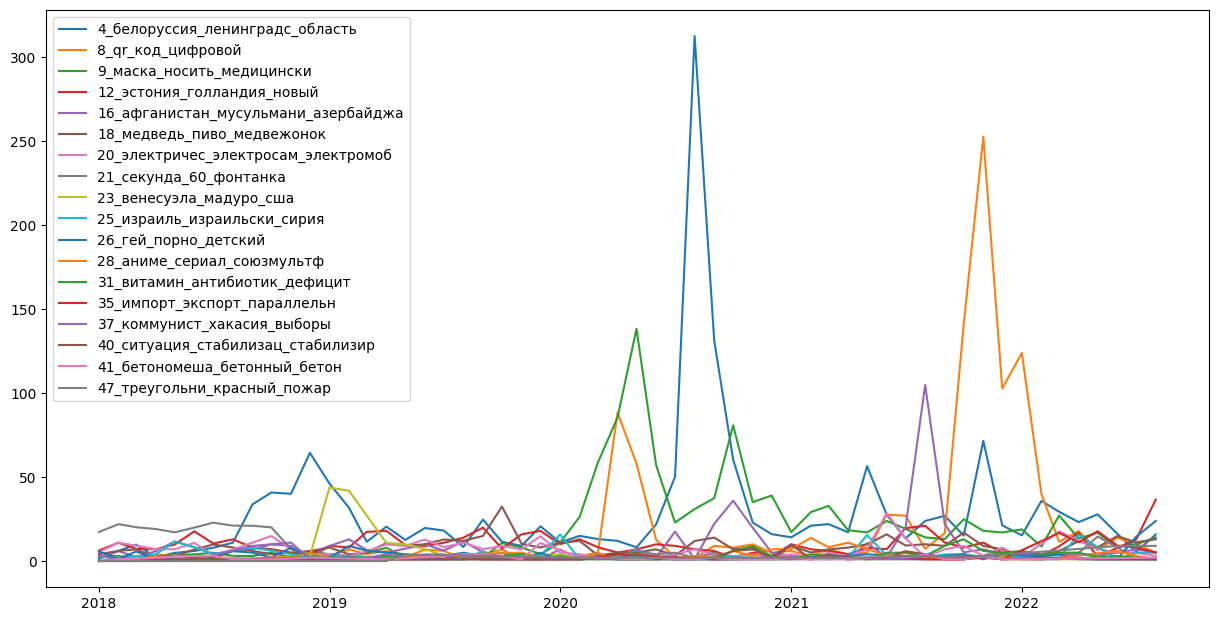

In [31]:
import statsmodels.tsa.api as smt

# Desired number of topics
desired_topics = 20

for threshold in np.arange(10.0, 0.1, -0.1):
    non_stat_topic_df = topic_df.copy()
    for col in non_stat_topic_df.columns:
        if non_stat_topic_df[col].max() / non_stat_topic_df[col].mean() < threshold:
            non_stat_topic_df = non_stat_topic_df.drop(columns=[col])
    # If num of topics is desired += 10%
    if np.abs(len(non_stat_topic_df.columns) - desired_topics) <= (desired_topics / 10):
        break

plt.plot(non_stat_topic_df);
plt.legend(non_stat_topic_df.columns);